# VIDUS HIV Acquisition GWAS: baseline (1df) & G$\times$Sex (2df)
__Author__: Jesse Marks <br>
**GitHub Issue**: [42](https://github.com/RTIInternational/bioinformatics/issues/42)

This document revisits the data processing on the [VIDUS](https://www.bccsu.ca/vidus/) EA data set. In particular, we are attempting to reproduce the results that had originally been processed by Nathan Gaddis and subsequently Fang Fang. For any general or specific questions regarding this protocol, speak with Eric O. Johnson.


__Genotype Data Location__: `s3:rti-hiv/vidus/data/genotype/{imputed,observed}`


**Note**: 7 samples were removed due to discrepant sex reports.

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* [ProbABEL](https://github.com/GenABEL-Project/ProbABEL)

## Variable information
**NGC Protocol Specifications:**
* OAall (coded 1 for all controls, 2 for OA cases)
* Sex (coded 1 for female, 2 for male)
* Any additional covariates (coded 1 for no, 2 for yes)
* Age (years)

## Data Description
### genotype 
`wc -l ea_chr_all.fam` <br>
* 941 

`wc -l ea_chr_all.bim` <br>
* 700,727 

### phenotype data 
Referring to the [VIDUS GitHub issue #42](https://github.com/RTIInternational/bioinformatics/issues/42), on Nov 19, 2018 Eric O. Johnson stated:

```css

The most recently complete source phenotype file is GWAS-Cohort-n938_passed_g_qc_only.dta. From this file and merging with VL & ART files, I created files for specific analyses:
GWAS for VL: gwas_vl_art_19feb2018.csv
GWAS for Acquisition: GWAS-Cohort-n938_passed _g_qc_HIV status_baseline.dta
GWAS heroin Cases: GWAS-Cohort-n938_passed_g_qc_only_CASE.dta
GWAS FOU: GWAS-Cohort-n938_passed_g_qc_only_FOU.dta
```

**variables**:
```
gwas_code,coh,int_date,DOB_YYYY,female,inj_ever,inj_l6m,borrow_ever,borrow_l6m,drug_noninj_ever,drug_noninj_l6m,num_partners2_ever,num_partners2_l6m,num_partners5_ever,num_partners5_l6m,sextrade_ever,sextrade_l6m,std_ever,std_l6m,anal_ever,anal_l6m,sex_hiv_ever,sex_hiv_l6m,hiv
```

* There are two samples that passed QC were not included in the phenotype data: 795, 1059
    - these respondents did not complete the interview/survey but provided blood
    
* There are 35 additional phenotype records missing HIV status, only 3 of these are among those with QC passing genotype data: 793, 819, 830.
    - Response from M-J (2-24-18) is that these are all HIV+
    
* Seven samples were removed for sex discrepancies

```css
Based on a comparison of s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Cohort-n938_passed_g_qc_only.csv and s3://rti-midas-data/studies/vidus/observed/unprocessed/Data_Transfer_12SEP2017/Reports/QC_Reports/Eric_Johnson_OmniExpress_re-analysis_A1_Manifest_QC-REPORT_AUG2017.xlsx
the following individuals that passed genotype QC have discrepant sexes and should be removed:

8005964966_NA0054149_93-0143
8005964978_NA0054150_93-0144
8015124413_NA0055272_93-0623
8015124401_NA0055273_93-0624
8015124354_NA0055285_93-0628
8005965380_NA0055556_93-0720
8005964955_NA0056463_93-1068
```
    
### file to use
We will use the file at the location: `rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Cohort-n938_passed_g_qc_only_HIV status_baseline.csv` which is for the baseline HIV acquisition GWAS. This data set is filtered down to only include:

```
gwas_code,female,hiv,ageatint
1,0,0,55
2,0,1,59
3,0,1,55
4,0,1,54
```
**Note**: that Jesse Marks had one more person pass genotype QC than Nathan Gaddis did in his original genotype QC of VIDUS. This subject is `8005964586_NA0054435_93-0328`. According to the original data set `GWAS-Data.xlsx` this subject is negative for HIV status. We will manually enter this line in our GWAS phenotype file:

```
gwas_code,female,hiv,ageatint
0328,0,0,64
```

We will rename this phenotype file to `20190211-GWAS-Cohort-n939_passed_g_qc_only-HIV_status_baseline.csv`

# Download Data and Create Directory Structure

In [ ]:
## bash ##

### create directory structure ###
genoD=/shared/jmarks/hiv/vidus/genotype/observed/final/002 # location of QC'ed genotype data
gwasD=/shared/jmarks/hiv/vidus/gwas # base processing dir
phenoD=/shared/jmarks/hiv/vidus/phenotype # base phenotype dir
eig=$phenoD/processing/eig # location of PCA processing dir
ancestry="ea"
study=vidus
mkdir -p $genoD $gwasD $phenoD/{final,processing,unprocessed} $eig/results 

### Download data & unzip ###
cd /shared/jmarks/hiv/vidus/phenotype/unprocessed
aws s3 cp s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Cohort-n938_passed_g_qc_only_HIV status_baseline.csv .
aws s3 cp s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Data.xlsx .
aws s3 cp s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Dictionary.pdf .

# Prepare files for Analysis
Note that we follow the process outlined in the NGC protocol for preperations of the phenotype file, even if we don't ultimately use RVTESTS for the analysis. This is so that the phenotype processing steps are consistent.

## Phenotype processing
Create phenotype files for GWAS. We follow the instructions of the NGC protocol distributed by Eric Johnson. This protocol mandates that we create a phenotype file and a covariate file in PED format. See the NGC protocol for more information on this format. There are several initial filters and processing steps to be applied to the subject data. 

* extract ids of subjects passing genotype QC
* phenotype variables of interest
    - `gwas_code`, `DOB_YYYY`, `female`, `hiv`
* Map sex coding and hiv status per the NGC protocol, to 1=female & 2=male. Currently, the mapping 0's and 1's.

### Data wrangling
Manually alter file `GWAS-Cohort-n938_passed_g_qc_only_HIV status_baseline.csv` to add the sample `8005964586_NA0054435_93-0328`. 

In [ ]:
# copy file from unprocessed to processing dir
cp $phenoD/unprocessed/GWAS-Cohort-n938_passed_g_qc_only_HIV\ status_baseline.csv\
    $phenoD/processing/vidus.phenotype.n939.hiv.baseline.csv

# add trailing zeros to entries in phenotype gwas_code to match genotype data code
awk -F "," 'NR>=2{ $1 = sprintf("%04d", $1) } {print $1,$2,$3,$4}' \
    vidus.phenotype.n939.hiv.baseline.csv  > vidus.ea.phenotype_table

# add sample "0328 0 0 64" to the file with vim
wc -l vidus.ea.phenotype_table
"""940 vidus.phenotype.n939.hiv.baseline.csv"""

# remove samples with sex discrepancies
grep --invert-match --file ../unprocessed/sex.remove vidus.ea.phenotype_table >\
    vidus.ea.phenotype_table.sex_removed

## map sex
#awk '{if ($2==0) {$2=2}}1' vidus.ea.phenotype_table.sex_removed > vidus.ea.phenotype_table.sex_mapped
#
## map hiv status (2=case)
#awk 'NR>=2{if ($3==1) {$3=2} else{$3=1}}1' vidus.ea.phenotype_table.sex_mapped > vidus.ea.phenotype_table.sex+hiv_mapped

Filter down to subjects with both genotype data (in \*fam plink file) and phenotype data. Note that since these phenotype data had already been processed by Eric Johnson and Nathan Gaddis, the samples list should be equal other than two samples that passed QC were not included in the phenotype data: 795, 1059

These respondents did not complete the interview/survey but provided blood. This is detailed in file `Phenotype.QC_recoding.documentation.pdf` that Eric Johnson outlined.

In [ ]:
### Bash ###

# get IDs of subjects with genotype data
cut -d ' ' -f2 $genoD/ea_chr_all.fam > $phenoD/processing/$study.ea.genotype.IDs

# if subject has genotype data, then keep
# EAs
#awk 'NR==FNR{map[substr($1 , length($1) -3 )]=$1;next}  FNR>=2{$1= map[$1]}1' \
#awk 'NR==FNR{map[substr($1 , length($1) -3 )]=$1;next}  FNR>=2{ if ($1 in map) {$1= map[$1]}}1' \
awk 'NR==FNR{map[substr($1 , length($1) -3 )]=$1;next} FNR==1{print$0} FNR>=2{ if ($1 in map) {$1 = map[$1]; print $0}}'  \
    $phenoD/processing/vidus.ea.genotype.IDs vidus.ea.phenotype_table.sex_removed >\
    $study.ea.phenotype_table.sex_removed.passed_qc
                    

wc -l $study.ea.phenotype_table.sex_removed.passed_qc
"""
932 vidus.ea.phenotype_table.sex_removed.passed_qc
"""


## generate new set of genotype data 
awk 'NR>=2{print $1,$1}' $phenoD/processing/$study.ea.phenotype_table.sex_removed.passed_qc > \
    $phenoD/processing/final_ids

/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $genoD/${ancestry}_chr_all \
    --keep $phenoD/processing/final_ids \
    --make-bed \
    --out $eig/$study.genotypes

**Note**: there was one subject that did not have genotype data.

Sample `8005964634_NA0054172_93-0164` was removed during the ibs_gt_0.9_ibd_gt_0.4 filter. 

0164 0 0 47

In [ ]:
#copy to local machine 

cd /home/jmarks/Desktop/Projects/HIV/vidus/phenotype
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/vidus/phenotype/processing/vidus.ea.phenotype_table.sex_removed.passed_qc .

In [3]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
myfile <- "vidus.ea.phenotype_table.sex_removed.passed_qc"
setwd('C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/phenotype')

ea.data <- read.table(myfile, header=T, colClasses = 
                      c("character", rep("double",  3)))

cat("female: 1", "\nmale: 0\n\n")
cat("control: 0", "\ncase: 1\n")
cat("--------------------------------------------------------------------------------\n\n")
cat("\n\nfemale/male count")
table(ea.data$female)
cat("\n\n\n\nEA: ages")
table(ea.data$ageatint)
cat("\n\nEA: Case/control")
table(ea.data$hiv)
cat("Head of EA table")
head(ea.data)
#ylimit = max(table(ea.data$ageatint))*3 
#hist(ea.data$ageatint, ylim=c(0,ylimit), breaks=20)

female: 1 
male: 0

control: 0 
case: 1
--------------------------------------------------------------------------------



female/male count


  0   1 
706 225 





EA: ages


18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 
 1  3  2  5  6  7  6  9 10 10 10 19  7 15 18 17 18 16 11 20 20 20 22 17 19 17 
44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 
19 37 28 28 25 37 36 40 44 33 34 39 30 35 23 21 18 18 11  9 13  7  8  5  3  2 
71 
 3 



EA: Case/control


  0   1 
681 250 

Head of EA table

gwas_code,female,hiv,ageatint
8005965211_NA0055425_93-0001,0,0,55
8005964642_NA0053910_93-0002,0,1,59
8005964654_NA0053915_93-0003,0,1,55
8005964666_NA0053918_93-0004,0,1,54
8005964583_NA0053919_93-0005,0,1,40
8005964584_NA0053917_93-0006,1,0,35


### PCA (EIGENSTRAT)
In the GWAS model, one should control from ancestry substructure. This is achieved by including the top genotype principal component as covariates in the GWAS statistical model. The software EIGENSTRAT can be used to perform the PCA. It is run on LD-pruned observed autosome genotypes for each ancestry group. 

#### Remove high-LD region variants

In [ ]:
## EC2 ##
## Remove high-LD region variants ##
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }'\
    $eig/$study.genotypes.bim > $eig/$study.genotypes.high_ld_regions.remove
            

# Remove SNPs in known high-LD regions
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $eig/$study.genotypes \
    --exclude $eig/$study.genotypes.high_ld_regions.remove \
    --make-bed \
    --out $eig/$study.genotypes.high_ld_regions_removed

 wc -l $eig/*bim
"""
700727 /shared/jmarks/hiv/vidus/phenotype/processing/eig/vidus.genotypes.bim
690233 /shared/jmarks/hiv/vidus/phenotype/processing/eig/ea_high_ld_regions_removed.bim
"""

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
### EC2 console ###

# note only perform on autosomes
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.${ancestry}.chr${chr}.ld_prune \
        --script_prefix $eig/${ancestry}_chr${chr}_ld_prune \
        --mem 3 \
        --nslots 2 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${ancestry}_chr${chr}_ld_pruned
done

# Merge *prune.in files
cat $eig/${ancestry}_chr*_ld_pruned.prune.in > $eig/${ancestry}_chr_all_ld_pruned.prune.in

# Create new PLINK filesets with only lD pruned variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $eig/$study.genotypes.high_ld_regions_removed \
    --extract $eig/${ancestry}_chr_all_ld_pruned.prune.in \
    --make-bed \
    --out $eig/$study.genotypes.ld_pruned

# Clean up
#rm $eig/*${ancestry}*ld_pruned.{prune.in,prune.out,log}
#rm $eig/*${ancestry}*ld_prune*qsub*
#rm $eig/*${ancestry}*high_ld_regions*
#rm $eig/*${ancestry}*chr23_ld_pruned.hh

wc -l $eig/*bim
""" 
  700727 vidus.genotypes.bim
  690233 vidus.genotypes.high_ld_regions_removed.bim
  124376 vidus.genotypes.ld_pruned.bim
"""

#### Rename BIM/FAM file IDs
Variant IDs in the PLINK `bim` file have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. The family IDs in the PLINK `fam` files similarly throw an error in `smartpca` should the number of characters in the IDs be more than 39. For this reason, we will apply an analogous renaming convention.

In [ ]:
### EC2 console ###

# Count ID lengths greater than 39 characters
# an example of an rsID that is too long is the following:
# rs141233280:245974067:GAAAGACGCACTTTTC:G
awk '{ if(length($1)+length($2)>39){print $2} }' $eig/$study.genotypes.ld_pruned.fam | wc -l
awk '{ if(length($2)>39){print $2} }' $eig/$study.genotypes.ld_pruned.bim | wc -l

# output is
"""
941
0
"""

## Rename fam file IDs
awk '{$1="ID_"NR; print $0}' $eig/$study.genotypes.ld_pruned.fam > $eig/$study.genotypes.ld_pruned.renamed.fam
awk '{ if(length($1)+length($2)>39){print $2} }' $eig/$study.genotypes.ld_pruned.renamed.fam | wc -l
"0"

**Note** we did not have to rename the bim files for this case.

#### Assign Cases and Controls
Modify the fam file to include case/control status. According to PLINK,

`Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)`

The NGC protocol is consistent with this assignment.

In [ ]:
phenofile="vidus.ea.phenotype_table.sex_removed.passed_qc"

## extract the IDs of controls 
tail -n +2 $phenoD/processing/$phenofile |\
    awk '{ if ($3==1) {print $1}}' > $eig/$ancestry.controls.ids

# Modify FAM file to include case/control status
awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
    $eig/$ancestry.controls.ids $eig/$study.genotypes.ld_pruned.renamed.fam >\
    $eig/$study.genotypes.ld_pruned.renamed.case+control.fam

#### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
### EC2 console ###
famfile="$eig/vidus.genotypes.ld_pruned.renamed.case+control.fam"
bimfile="$eig/$study.genotypes.ld_pruned.bim"
bedfile="$eig/$study.genotypes.ld_pruned.bed"

# Run smartpca
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.smartpca \
    --script_prefix $eig/smartpca.$study.${ancestry} \
    --mem 7.5 \
    --nslots 1 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${ancestry}_ld_pruned.pca \
        -p $eig/results/${ancestry}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0

#### Extract Eigenvectors

In [ ]:
# Grab top 10 eigenvectors from PCA 
echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
tail -n +2 $eig/results/${ancestry}_ld_pruned.pca.evec | \
    perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
    >> $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt

# copy to local

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [1]:
#cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/vidus/pca
#scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/vidus/phenotype/processing/eig/results/* .

### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/pca/")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
ea.evec[,1:5]

,V2,V3,V4,V5,V6
ID_1:8005964577_NA0054973_93-0527,-0.0078,-0.0068,0.0007,-0.0014,-0.0070
ID_2:8005964578_NA0054508_93-0381,-0.0055,-0.0061,-0.0026,-0.0086,-0.0042
ID_3:8005964579_NA0054695_93-0482,0.0004,-0.0042,-0.0022,-0.0027,-0.0051
ID_4:8005964580_NA0054659_93-0222,0.0086,0.0137,0.0125,-0.0013,0.0094
ID_5:8005964581_NA0054679_93-0478,0.0129,0.0343,0.0011,-0.0026,-0.0030
ID_6:8005964582_NA0054694_93-0481,-0.0084,-0.0093,0.0081,0.0003,0.0042
ID_7:8005964583_NA0053919_93-0005,0.1492,0.2539,0.0105,-0.0079,-0.0072
ID_8:8005964584_NA0053917_93-0006,-0.0118,-0.0045,0.0054,-0.0008,0.0024
ID_9:8005964585_NA0054439_93-0332,0.0042,0.0065,0.0055,-0.0012,-0.0008
ID_10:8005964586_NA0054435_93-0328,0.7677,-0.5180,0.3455,0.0234,0.0119


##### EA

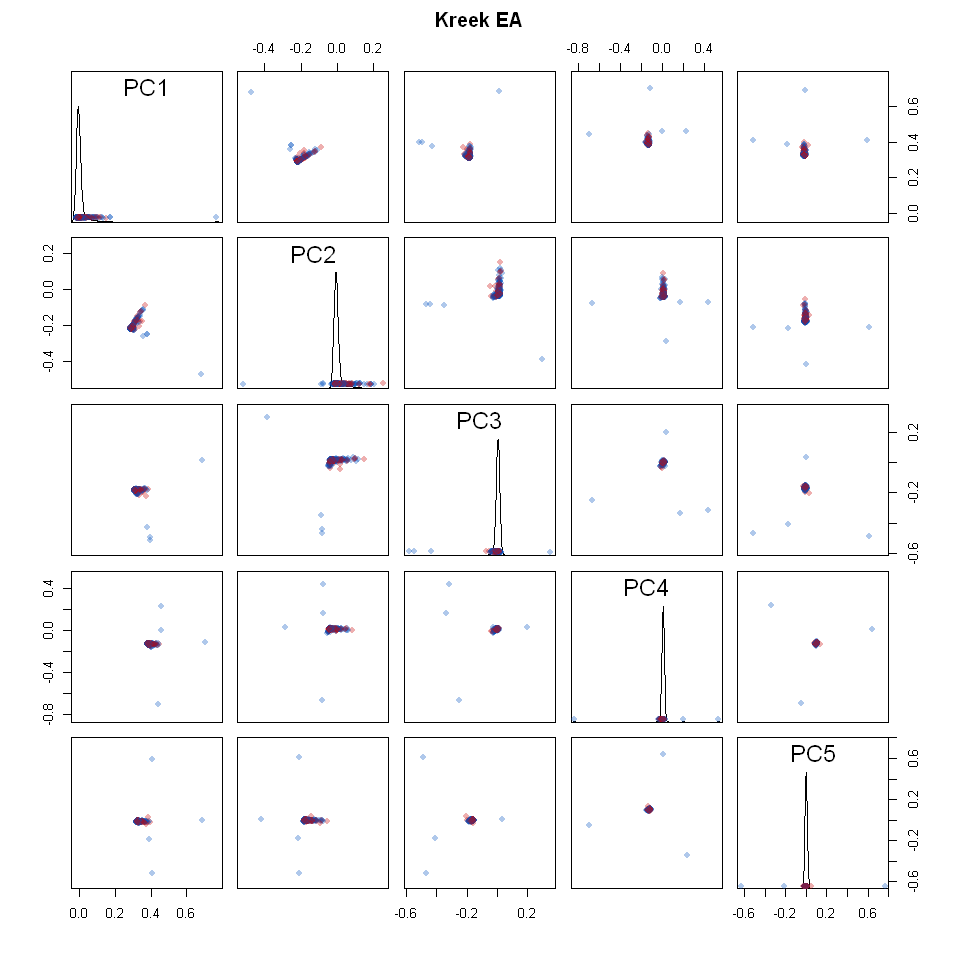

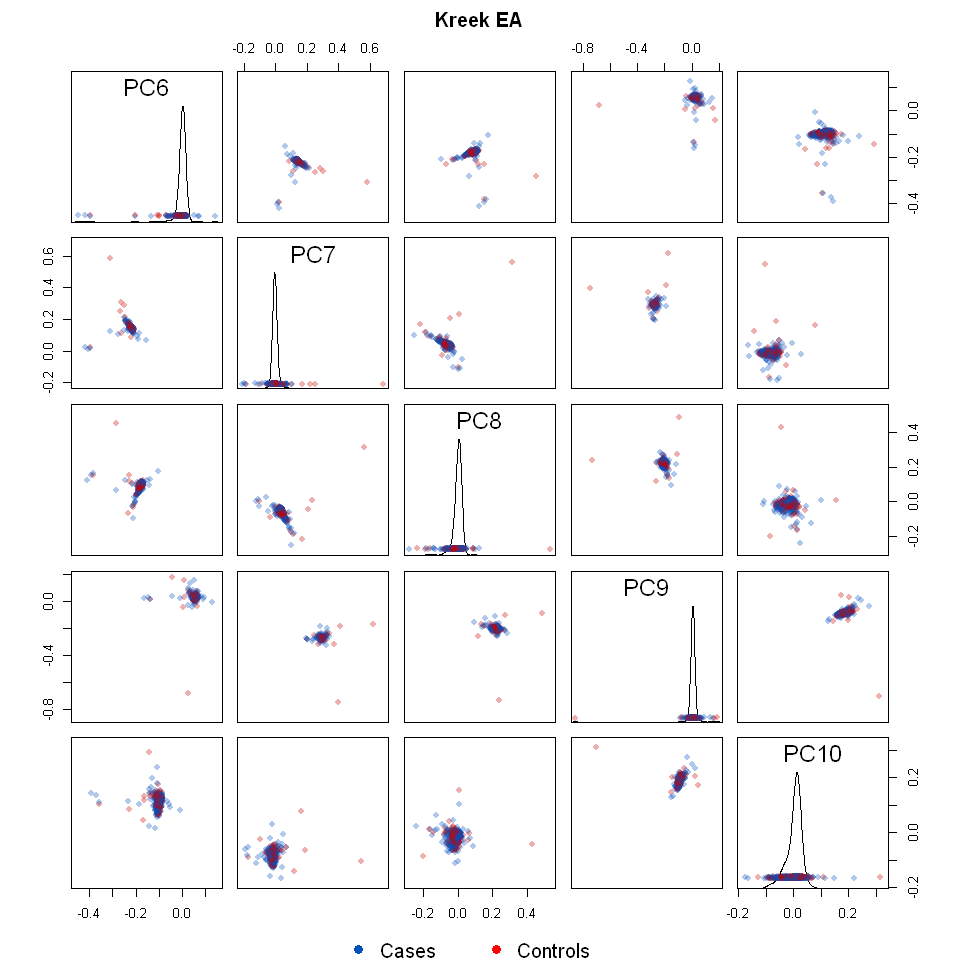

In [2]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)
legend("bottom", c("Cases", "Controls"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


### EA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.
Make PED format phenotype and covariate file according to the NGC protocol.

#### Create PED files
The covariates we want to include in this baseline GWAS are age, sex, and some of the most influential PCs. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain  ∼75%  of the variance.

In [3]:
#mkdir /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/phenotype/final

### R (local) ###

## Phen file
#------------------------------------------------------------------------------------------
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/phenotype/")
p.data <- "vidus.ea.phenotype_table.sex_removed.passed_qc"
study <- "vidus"

pheno.data.ea <- read.csv(p.data, sep = " ", header = TRUE, stringsAsFactors = F, 
                       colClasses=c( "character", rep("double",  3)))

head(pheno.data.ea)
pca.data.ea <- read.csv("../pca/ea_ld_pruned_top10_eigenvecs.txt",
                     sep = " " , header=T, colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects.ea <- length(pca.data.ea[,1])

ped.file.ea <- data.frame(matrix(ncol = 6, nrow = num.subjects.ea))
colnames(ped.file.ea) <- c("fid", "iid", "patid", "matid", "sex",  "hiv")
ped.file.ea[,1] <- pheno.data.ea[,1]
ped.file.ea[,2] <- pheno.data.ea[,1]
ped.file.ea[,"sex"] <- pheno.data.ea[,"female"]
ped.file.ea[,"hiv"] <- pheno.data.ea[,"hiv"]


head(ped.file.ea)
write.table(ped.file.ea[,1:6], paste(study,"_EUR_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)


#----------------------------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude oaall data)
col.names.ea <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.ea <- length(col.names.ea)
covar.data.ea <- data.frame(matrix(ncol = num.columns.ea, nrow = num.subjects.ea))
names(covar.data.ea) <- col.names.ea

num.covs.ea <- length(ped.file.ea) - 1
covar.data.ea[,1:num.covs.ea] <- ped.file.ea[,1:num.covs.ea] # fid, iid, patid, matic, sex
covar.data.ea[,num.covs.ea+1] <- pheno.data.ea[,4] # age 

covar.data.ea[,(num.covs.ea+2):length(col.names.ea)] <- pca.data.ea[,3:length(pca.data.ea)]

head(covar.data.ea)
length(covar.data.ea[,1])

write.table(covar.data.ea, paste(study, "_EUR_cov.ped", sep=""), quote=FALSE, row.names = FALSE, sep = "\t")

gwas_code,female,hiv,ageatint
8005965211_NA0055425_93-0001,0,0,55
8005964642_NA0053910_93-0002,0,1,59
8005964654_NA0053915_93-0003,0,1,55
8005964666_NA0053918_93-0004,0,1,54
8005964583_NA0053919_93-0005,0,1,40
8005964584_NA0053917_93-0006,1,0,35


fid,iid,patid,matid,sex,hiv
8005965211_NA0055425_93-0001,8005965211_NA0055425_93-0001,NA,NA,0,0
8005964642_NA0053910_93-0002,8005964642_NA0053910_93-0002,NA,NA,0,1
8005964654_NA0053915_93-0003,8005964654_NA0053915_93-0003,NA,NA,0,1
8005964666_NA0053918_93-0004,8005964666_NA0053918_93-0004,NA,NA,0,1
8005964583_NA0053919_93-0005,8005964583_NA0053919_93-0005,NA,NA,0,1
8005964584_NA0053917_93-0006,8005964584_NA0053917_93-0006,NA,NA,1,0


fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
8005965211_NA0055425_93-0001,8005965211_NA0055425_93-0001,NA,NA,0,55,-0.0078,-0.0068,0.0007,-0.0014,-0.0070,0.0038,0.0141,-0.0164,0.0159,0.0197
8005964642_NA0053910_93-0002,8005964642_NA0053910_93-0002,NA,NA,0,59,-0.0055,-0.0061,-0.0026,-0.0086,-0.0042,-0.0159,0.0003,-0.0044,-0.0027,0.0164
8005964654_NA0053915_93-0003,8005964654_NA0053915_93-0003,NA,NA,0,55,0.0004,-0.0042,-0.0022,-0.0027,-0.0051,-0.0152,0.0145,-0.0473,-0.0151,-0.0584
8005964666_NA0053918_93-0004,8005964666_NA0053918_93-0004,NA,NA,0,54,0.0086,0.0137,0.0125,-0.0013,0.0094,-0.0005,-0.0156,0.0217,-0.0089,0.0061
8005964583_NA0053919_93-0005,8005964583_NA0053919_93-0005,NA,NA,0,40,0.0129,0.0343,0.0011,-0.0026,-0.0030,0.0032,-0.0091,-0.0082,-0.0063,-0.0298
8005964584_NA0053917_93-0006,8005964584_NA0053917_93-0006,NA,NA,1,35,-0.0084,-0.0093,0.0081,0.0003,0.0042,0.0040,-0.0051,-0.0004,-0.0216,0.0067


[1] 931

In [4]:
### R console ###
# Load PCA data
#setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181128/phenotype/")

options(stringsAsFactors=F)
ea.cov.data <- read.delim(paste(study, "_EUR_cov.ped", sep=""), header=T, sep="\t")
ea.phen.data <- read.delim(paste(study, "_EUR_phen.ped", sep=""), header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "hiv"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(ea.data)

iid,hiv,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
8005964577_NA0054973_93-0527,0,-0.0108,-0.0023,0.0043,0.0021,0.0056,0.0127,-0.0093,0.0195,-0.0028,-0.0056
8005964578_NA0054508_93-0381,0,-0.0073,0.0024,0.0039,-0.0049,0.0031,-0.0046,0.0108,-0.0151,-0.0224,-0.0429
8005964579_NA0054695_93-0482,1,0.0128,-0.0187,-0.0248,-0.0181,0.0002,-0.2045,-0.0314,-0.0428,0.0094,-0.0048
8005964580_NA0054659_93-0222,0,-0.0040,0.0074,0.0066,-0.0008,0.0044,0.0064,0.0023,0.0079,-0.0098,-0.0543
8005964581_NA0054679_93-0478,0,-0.0090,-0.0049,0.0031,0.0001,0.0023,0.0022,-0.0032,0.0221,-0.0058,0.0171
8005964582_NA0054694_93-0481,0,0.0428,0.0743,0.0078,-0.0079,-0.0011,0.0083,-0.0046,0.0157,0.0021,-0.0113


#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{Phenotype = PC1 + PC2 + ... + PC10}
\end{align}$$

In [47]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
#lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)
glm.fit.ea <- glm(formula=as.formula(model.str), data=ea.data, family = binomial(link = "logit"))

# Get sequential (type I) sum of squares
#anova.ea <- anova(lm.fit.ea)
anova.ea <- anova(glm.fit.ea)

# Calculate percent variance explained and sort
#ea.pve <- cbind(anova.ea[pc.names,], 
#                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Deviance"]/sum(anova.ea[pc.names, "Deviance"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
#summary(lm.fit.ea)
summary(glm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 hiv ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



================ EA group ================


Call:
glm(formula = as.formula(model.str), family = binomial(link = "logit"), 
    data = ea.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3701  -0.7873  -0.7424   1.3954   1.7990  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.97507    0.08011 -12.172   <2e-16 ***
PC1          28.29821   17.26081   1.639    0.101    
PC2         -12.82955   11.88341  -1.080    0.280    
PC3           5.16614   14.19954   0.364    0.716    
PC4         -15.08198   12.63397  -1.194    0.233    
PC5         -12.06717   11.95941  -1.009    0.313    
PC6           2.38825    3.49667   0.683    0.495    
PC7          -3.86461    4.60460  -0.839    0.401    
PC8           1.20604    3.38734   0.356    0.722    
PC9          -6.59252    5.81561  -1.134    0.257    
PC10          0.20709    3.19780   0.065    0.948    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1

,Df,Deviance,Resid. Df,Resid. Dev,PVE
PC1,1,11.786729025,929,1071.506,52.35
PC5,1,4.682495045,925,1064.943,20.80
PC9,1,3.360591589,921,1060.780,14.93
PC3,1,1.218713567,927,1070.146,5.41
PC7,1,0.728210864,923,1064.208,3.23
PC4,1,0.520209088,926,1069.625,2.31
PC2,1,0.141492659,928,1071.364,0.63
PC8,1,0.067281554,922,1064.141,0.30
PC6,1,0.006247277,924,1064.937,0.03
PC10,1,0.004227241,920,1060.776,0.02


#### Percent Variance Explained Visualization

Top PCs:  PC1 PC5 PC9 
PVE:      88.08

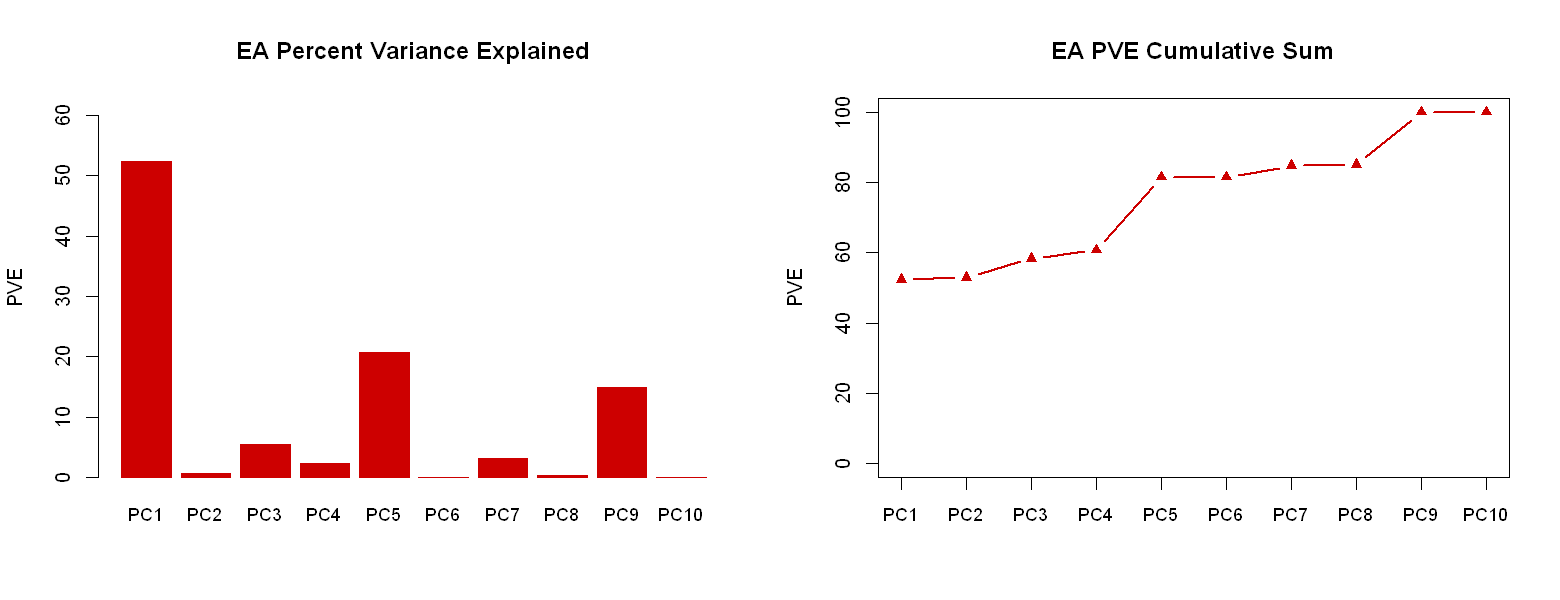

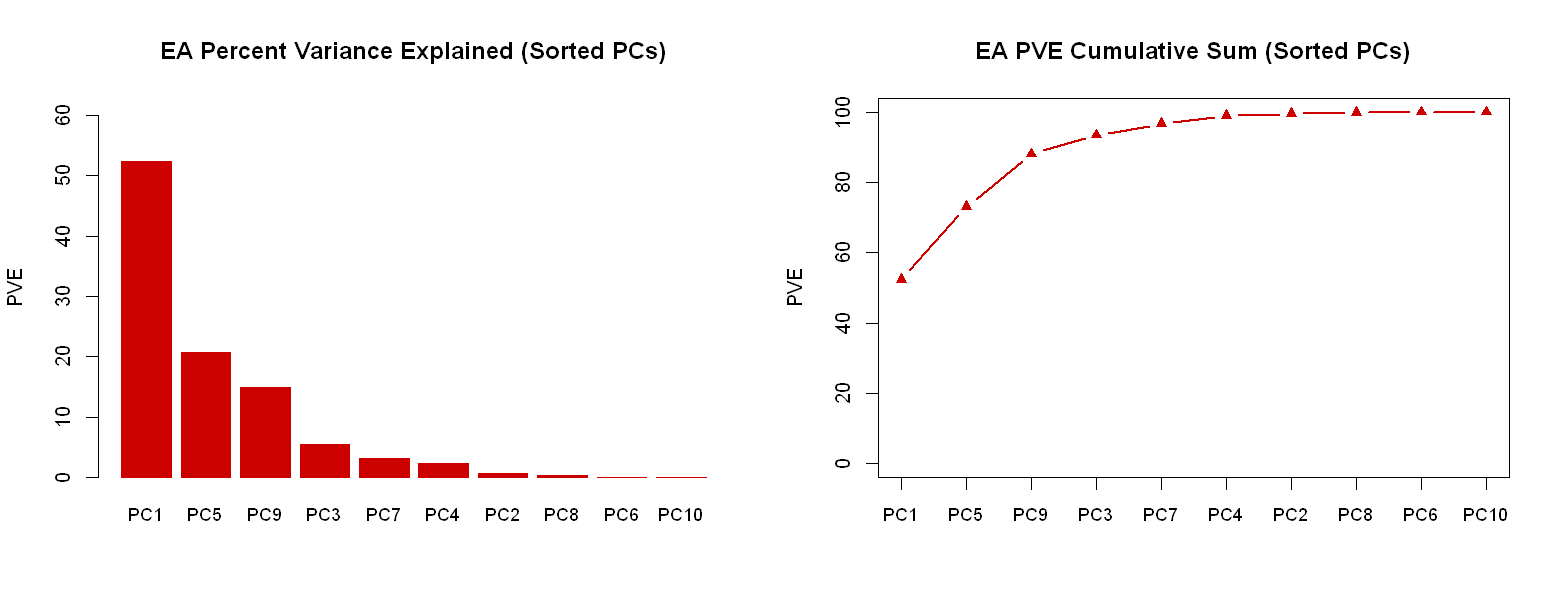

In [48]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor <- 0.9
barplot.ylim.ea <- c(0, max(ea.pve$PVE)*1.2)

pv_list <- vector(length = 10)
total <- 0
for (i in 1:nrow(ea.pve.sorted)){
    pv_list[i] <- row.names(ea.pve.sorted[i,])
    total <- total + ea.pve.sorted[i, "PVE"]
    #print(total)
    if (total >= 75) break
}

topPCs <- pv_list[which(pv_list != "FALSE")]
cat("Top PCs: ",topPCs, "\n")
cat(paste("PVE:     ", total))

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)


Based on these results we will use PC1, PC5, PC9. These PCs explain ~88% of the variance. 

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
#upload to EC2
scp -i ~/.ssh/gwas_rsa *ped ec2-user@34.206.166.72:/shared/jmarks/hiv/vidus/phenotype/processing

study=vidus
## EA ##
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' ${study}_EUR_cov.ped > ../final/${study}_NGCW1_EUR_cov.ped
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' ${study}_EUR_phen.ped > ../final/${study}_NGCW1_EUR_phen.ped

### ProbABEL format for phenotype file
The format of the phenotype thus far has follows the protocol of the NGC protocol, and therefore the phenotype file format is prepared for RVTESTS. Since we are using the ProbABEL software for these analysis we will format the phenotype file to be of the  form:
```
IID    PHENOTYPE    OTHER_COVARIATES
```
where `OTHER_COVARIATES` could be sex, age, PCs, etc. 

**Note**: additional phenotype processing will have to be done once the genotype data are processed. In particular, we will first get the IDs of the samples in the phenotype file. Then we will filter the genotype (imputed) data down to those subjects in the phenotype file. We will get the order of the subjects in the genotype data and then reorder our phenotype data to be the same order; this is more efficient than trying to reorder every genotype file. The formatting issue we address regarding the phenotype file is the coding of case/control status as well as other binary variables. Since we formatted the data per the NGC protocol, the case/control status is coded as `control=1, case=2`. The ProbABEL software dictates that the binary phenotype variable is to be coded as 0s & 1s, presumably control=0, case=1. We go ahead and recode the sex variable to this standard as well.

In [ ]:
## R ##
setwd("/shared/jmarks/hiv/vidus/phenotype/final")
out_name <- "vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt"

pheno <- "HIV_ACQ"
pcs = c("PC9", "PC5", "PC1")
other_covs <- c("AGE", "SEX", pcs)
cov_file <- "vidus_NGCW1_EUR_cov.ped"
pheno_file <- "vidus_NGCW1_EUR_phen.ped"

# read in data files
my_pheno <- read.table(pheno_file, header=T)
my_cov <- read.table(cov_file, header=T)

num.subjects <- length(my_cov[,1])
    

# create new phenotype file (dataframe)
num_cols = 2 + length(other_covs) # IID + pheno + covs
covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
names(covar.data) <- c("IID", pheno, other_covs)
covar.data[1] <- my_pheno$iid
covar.data[2] <- my_pheno$hiv
covar.data[3] <- my_cov$age
covar.data[4] <- my_cov$sex
covar.data[5] <- my_cov$PC9
covar.data[6] <- my_cov$PC5
covar.data[7] <- my_cov$PC1
head(covar.data)

write.table(x = covar.data, file = out_name, quote = F, row.names = F)

In [ ]:
## bash ##

# make phenotype binary of (0,1) and sex too 
# this makes hiv control 0 and case 1; female 0 and male 1
#awk ' NR>=2{$2=$2-1}{print $0}' vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt > \
#    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.binary.txt
#awk ' NR>=2{$4=$4-1}{print $0}' vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.binary.txt > tmp \
#    && mv tmp vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC1.binary.txt

## Genotype Data
Prepare Genotype Data for analysis software.
### Inflate imputation results
These data were imputed on the Michigan Imputation Server and therefore need to be inflated.
### merge chrX
The chrX imputed data from the Michigan Imputation Server is split between males and females. We need to merge these data for the GWAS because the other data is not split by sex. We control for that with a sex covariate.

Email from Fang Fang:
```css
I used `bcftools` to merge vcf files.

One thing I want to mention is that when you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.
```

**bcftools parameters** <br>
The following information was copied from `/shared/bioinformatics/software/third_party/bcftools-1.6/doc/bcftools.txt`
```
*-O, --output-type* 'b'|'u'|'z'|'v'::
    Output compressed BCF ('b'), uncompressed BCF ('u'), compressed VCF ('z'), uncompressed VCF ('v').
    Use the -Ou option when piping between bcftools subcommands to speed up
    performance by removing unnecessary compression/decompression and
    VCF<-->BCF conversion.
    
*-o, --output* 'FILE'::
    When output consists of a single stream, write it to 'FILE' rather than
    to standard output, where it is written by default.    
```

In [ ]:
imputedir=/shared/jmarks/hiv/vidus/genotype/impute/final/ea/chrx
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name bmerge \
    --script_prefix ${imputedir}/bmerge \
    --mem 7.5 \
    --nslots 2 \
    --priority 0 \
    --program "/shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
        ${imputedir}/chrX.no.auto_male.dose.vcf.gz ${imputedir}/chrX.no.auto_female.dose.vcf.gz \
        -O z -o ${imputedir}/chrX.no.auto.vcf.gz"

### Convert format: dose to mach
The ProbABEL software requires the data to be formatted differently than the VCF format that is the output from MIS. In particular, we need to convert the VCF files (dosage) to MaCH format.

In [ ]:
base_dir=/shared/jmarks/hiv/vidus/genotype/impute/final/ea

# autosomes
for chr in {1..22};do
    chr_location=${base_dir}/mach/chr${chr}
    mkdir -p $chr_location

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name convert_dosage_chr${chr} \
        --script_prefix $chr_location/chr${chr}.convert \
        --mem 10 \
        --buffer 100000 \
        --nslots 3 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
            --vcfDose ${base_dir}/auto/chr${chr}.dose.vcf.gz \
            --info ${base_dir}/chr${chr}.info.gz \
            --prefix $chr_location/chr${chr} \
            --type mach \
            --format 1 # contains the expected alternate allele count (one value per sample per marker).
done

# chrX
chr=23
chr_location=${base_dir}/mach/chr${chr}
mkdir -p $chr_location
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name convert_dosage_chr${chr} \
    --script_prefix ${chr_location}/chr${chr}.convert \
    --mem 10 \
    --buffer 100000 \
    --nslots 3 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose ${base_dir}/chrx/chrX.no.auto.dose.vcf.gz \
        --prefix ${chr_location}/chr${chr} \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).

#### chrX info file
**Note:** about chrX. When you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.

```css
The info file generated by minimac3/4 at the same time as the VCF dosage file
(This parameter is optional, but if NO info file is provided, the output MaCH info file will have missing columns.)
```

female unique SNPs (18):
```
X:48797086      C       T       0.00877 0.00877 -       -       Typed_Only      -       -       -       -       -
X:53460906      C       T       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59063483      T       C       0.11842 0.11842 -       -       Typed_Only      -       -       -       -       -
X:59099494      T       C       0.00439 0.00439 -       -       Typed_Only      -       -       -       -       -
X:59134135      A       G       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59178058      T       C       0.00439 0.00439 -       -       Typed_Only      -       -       -       -       -
X:59189481      A       G       0.03728 0.03728 -       -       Typed_Only      -       -       -       -       -
X:59213338      G       A       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:59251895      G       A       0.06360 0.06360 -       -       Typed_Only      -       -       -       -       -
X:59262486      C       A       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:59282717      G       A       0.01316 0.01316 -       -       Typed_Only      -       -       -       -       -
X:59332968      T       C       0.01974 0.01974 -       -       Typed_Only      -       -       -       -       -
X:63091629      C       A       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:70625141      T       C       0.00219 0.00219 -       -       Typed_Only      -       -       -       -       -
X:88685058      C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:128778535     C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:134303025     C       A       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
X:134315090     C       T       0.00658 0.00658 -       -       Typed_Only      -       -       -       -       -
```

male unique SNPs (8):
```
X:48349873      G       A       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:48772479      C       T       0.00141 0.00141 -       -       Typed_Only      -       -       -       -       -
X:50058760      A       G       0.00143 0.00143 -       -       Typed_Only      -       -       -       -       -
X:70330483      C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:75651394      T       C       0.00141 0.00141 -       -       Typed_Only      -       -       -       -       -
X:101857367     C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
X:153230408     G       A       0.00281 0.00281 -       -       Typed_Only      -       -       -       -       -
X:153629663     C       T       0.00140 0.00140 -       -       Typed_Only      -       -       -       -       -
```

These were `genotyped-only` SNPs. When we create the info file, we will either exclude these 18 SNPs or handle them separately when we merge the male and female data.

### Prune mach files 

The converted genotype data (mach format) files need to be reorder and pruned to match the subjects in the phenotype file. 
Pg. 7 of the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) reports that the genomic predictor file—which is the dosage file—has in the first column a sequential ID, followed by an arrow followed by the study ID.

We will first get a list of the IDs from the phenotype file.

**Note**: for this case, we had to remove 7 subjects that had sex discrepancies. 

In [ ]:
### python ##
#"""
#remove sex discrepancies from phenotype file
#"""
#import os
#
#os.chdir("/shared/jmarks/hiv/vidus/phenotype/final")
#
#infile = "vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt"
#sex_ids = "sex.discrepancies" # list of 7 subjects to be removed
#outfile = "vidus.ea.HIV_ACQ.AGE.SEX.PC9+PC4+PC1.removed_sex_conflict.binary.txt"
#
#with open(infile) as inF, open(sex_ids) as sexF, open(outfile, 'w') as outF:
#    sex_set = set()
#    
#    for line in sexF:
#        sex_set.add(line.strip())
#        
#    head = inF.readline()
#    line = inF.readline()
#    outF.write(head)
#    while line:
#        ids = line.split()[0]
#        half = ( len(ids) - 1 ) / 2
#        ids = ids[0:half]
#        if ids not in sex_set:
#            outF.write(line)
#        
#        line = inF.readline()
################################################################################# 
#

In [ ]:
## bash ## 
cd /shared/jmarks/hiv/vidus/phenotype/final
tail -n +2 vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt | cut -d" " -f1 > phenotype.ids
cp phenotype.ids /shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach

wc -l phenotype.ids
"""931"""

In [ ]:
## python ##
"""
processing.genotype.files.py

This script will process the mach.dose genotype files.
In particular, it will remove any subjects that are not
the phenotype file. It will output the new filtered mach.dose
file as well as a file that contains the order of the subject
IDs in the genotype files. We will then use this information to
reorder the phenotype file.

input: chrom name_of_order_file

where chrom is the chromosome to process and name_of_order_file is the 
output name of the file that contains the order of the samples in the genoytpe data
"""
import gzip, sys, os

os.chdir("/shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach")

chrom = sys.argv[1]
order_name = sys.argv[2]

print(chrom)
myfile = "chr{0}/chr{0}.mach.dose.gz".format(chrom)
keep_ids = "phenotype.ids"
outfile = "chr{0}/chr{0}.mach.dose.filtered".format(chrom)
out_order = "chr{0}/{1}".format(chrom, order_name)

order.of.genotype.ids
with gzip.open(myfile) as inF, open(keep_ids) as sexF, open(outfile, 'w') as outF, open(out_order, "w") as outID:
    sex_set = set()
    for line in sexF:
        sex_set.add(line.strip())

    line = inF.readline()
    count = 1
    while line:
        sl = line.split()
        gen_id = sl[0].split("->")[0]
        if gen_id in sex_set:
            sl[0] = "{}->{}".format(count, gen_id)
            count += 1
            newline = " ".join(sl)
            outF.write(newline + "\n")
            outID.write(gen_id + "\n")

        line = inF.readline()

    message = "chr{0} all done!".format(chrom)
    print(message)

In [ ]:
## bash ##
cd /shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach

# autosomes
for chr in {1..23};do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name chr$chr.gen.data.processing \
            --script_prefix chr$chr/chr$chr.mach.formatting \
            --mem 20 \
            --nslots 3 \
            --program time python processing.genotype.files.py $chr order.of.genotype.ids
done

### Reorder phenotype file
Reorder the phenotype file to be of the same order as the genotype files. 

**Note** the autosomes and chrX will have different orders and will therefore require different phenotype files. This is because chrX is imputed separately for males and females on the Michigan Imputation Server. We have to merge the data after we get them which results in the genotype data being in a disparate order than the autosomes. It might be handier if we just reorder chrX genotype file to be the same order as the autosomes so that we don't have to have to different phenotype files.

In [ ]:
cd /shared/jmarks/hiv/vidus/phenotype/final

ln -s /shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach/chr1/order.of.genotype.ids .
ln -s /shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach/chr23/order.of.genotype.ids.chrx .



# autosomes
head -1 vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt >\
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt
awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt order.of.genotype.ids >>\
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt

# chrX
head -1 vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt >\
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt
awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.txt order.of.genotype.ids.chrx >>\
    vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt

### create legend
Pg. 10 of the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) reports that the legend should be in HapMap format:

rsID, position, allele1, allele2

Note: We do not have the rsID right now. We have the chromosome and the position. It shouldn't be to difficult to convert this to the actual rsID. We might be able to use Nathan Gladdis' Nyholt script to convert these. This can be converted later, though. Also, this is an optional file. The only column that is actually used is the SNP location.

In [ ]:
## EC2 console ##
machD=/shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach

# HapMap "legend" file format
# note that our data is not in rsID format - we have chr:position for the rsID instead
for chr in {1..23}; do
    # print header
    echo "id position 0 1" > $machD/chr$chr/map.chr$chr.legend
    # grab the SNP, position, allele1 and allele2
    tail -n +2 $machD/chr${chr}/*info | awk '{pos = $1; gsub(/^.+:/, "", pos); print $1,pos,$2,$3}' >>\
        $machD/chr$chr/map.chr$chr.legend
done &

### Format info file
The ProbABEL manual specifies that the info file should have exactly 7 columns.

In [ ]:
## bash ##

machD=/shared/jmarks/hiv/vidus/genotype/impute/final/ea/mach

for chr in {1..23}; do
    cut -f 1-7 $machD/chr${chr}/chr${chr}.mach.info > $machD/chr$chr/chr$chr.mach.pruned.info & \
done

# Start ProbABEL Analysis (logistic model)
Perform GWAS. Consult [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) for details about software parameters.

| Ancestry | cases | controls | Total |
|----------|-------|----------|-------|
| EUR      |  681  |  250     | 931   |


## EA Baseline GWAS
PC9, PC4, & PC1

In [ ]:
## create directory structure 
version=001 
study=vidus
model=1df
covars="sex,age,PC1,PC5,PC9"
ancestry="ea"
phenoF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt"
phenoXF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt"
dose_suffix="mach.dose.filtered"
info_suffix="mach.pruned.info"

genD=/shared/jmarks/hiv/vidus/genotype/impute/final/$ancestry/mach
procD=/shared/jmarks/hiv/vidus/gwas/$ancestry/$model/$version
phenD=/shared/jmarks/hiv/vidus/phenotype/final
mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}

################################################################################
## perform GWAS (logistic)
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name probabel_gwas_chr${chr} \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palogist \
            --pheno ${phenD}/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --out $procD/processing/chr${chr}/chr${chr}.palogist.results
done


chr=23
# chrx has a different order phenotype file because the dose file is ordered by sex
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name probabel_gwas_chr${chr} \
    --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palogist \
        --pheno ${phenD}/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --out $procD/processing/chr${chr}/chr${chr}.palogist.results

### Check for completion

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

### Results Processing
#### Calculate chi, P, and OR

In [ ]:
baseDir=/shared/jmarks/hiv/vidus/gwas/ea/1df/001/processing
study=vidus
ancestry=ea
MODEL=HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9

for (( chr=1; chr<24; chr++ )); do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ea_$chr \
        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --mem 15 \
        --nslots 1 \
        --priority 0 \
        --program Rscript ~/bin/calculate_stats_for_probabel_results.R \
            --in_file $baseDir/chr$chr/chr$chr.palogist.results_add.out.txt \
            --out_file $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --complete
done

#### convert name to 1000G_p3

In [ ]:
cd /shared/jmarks/hiv/vidus/gwas/ea/1df/001/processing/
for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name vidus_1000g_p3_${chr}_name \
        --script_prefix chr$chr/name_conversion \
        --mem 15 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in chr$chr/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.stats \
            --file_out chr$chr/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.stats.converted \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col  0 \
            --file_in_chr_col  1 \
            --file_in_pos_col  2 \
            --file_in_a1_col  3 \
            --file_in_a2_col  4 \
            --chr $chr
done


chr=23
bash /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name vidus_1000g_p3_${chr}_name \
    --script_prefix chr$chr/name_conversion \
    --mem 15 \
    --nslots 1 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in chr$chr/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.stats \
        --file_out chr$chr/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.stats.converted \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 1 \
        --file_in_id_col  0 \
        --file_in_chr_col  1 \
        --file_in_pos_col  2 \
        --file_in_a1_col  3 \
        --file_in_a2_col  4 \
        --chr $chr 

### Filter results
MAF filters in study and 1000G, as well as imputation quality (r^2) filter.

**Note**, according to Fang Fang, when you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.
#### MAF > 0.01 in Study

In [ ]:
## EC2 console ##

# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=ea
    for ((chr=1; chr<24; chr++));do
        processingDir=/shared/jmarks/hiv/vidus/gwas/$ancestry/1df/001/processing/chr$chr
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 $processingDir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted > \
            $processingDir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            $processingDir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> $processingDir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats
    done 
#done

#### MAF > 0.01 in 1000G

In [ ]:
baseDir=/shared/jmarks/hiv/vidus/gwas/ea/1df/001/processing
if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
group=eur
for chr in {1..22};do
   awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
done &

# chrX
chr=23
awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}


#for ancestry in ea aa; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "ea" ]; then
        group=eur
    fi
    for chr in {1..23}; do
        base_dir=$baseDir/chr$chr
        idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
        echo "Processing chr${chr}_${ancestry}"      
        /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
            --source $base_dir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
            --id_list $idList \
            --out $base_dir/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
            --header 1 \
            --id_column 0 
    done &
done

#### RSQ >= 0.30

In [ ]:
## Filter by R^2
for chr in {1..23}; do
    echo -e "${ancestry} chr${chr}..."
        awk '{ if ($9 > 0.3){ print $0 } }' \
            $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.stats >\
             $procD/final/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
done

mv $procD/processing/chr*/$study.$ancestry.1000G_p3.chr*.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats \
    $procD/final/


## chrX note that imputed data are split up by males & females (229F 709M)
## perform the filtering on both male and female data and then merge results
#chr=23
#echo -e "${ancestry} chr${chr}..."
#zcat $genD/chr$chr/chrX.no.auto_male.info.gz | \
#    tail -n +2 | \
#    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
#    > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp
#
#echo -e "${ancestry} chr${chr}..."
#zcat $genD/chr$chr/chrX.no.auto_female.info | \
#    tail -n +2 | \
#    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
#    >> $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

## keep only SNPs that passed filters for both males and females
#sort $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp |\
#    uniq -d > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep

# Filter results files
cat $procD/processing/chr*/${study}.$ancestry.chr*.tmp | gzip -c > $procD/final/${study}.${ancestry}.hiv_acq.maf_gt_0.01.rsq_gt_0.3.gz


# cleanup
#rm $procD/processing/chr*/*tmp 




### Plot results

In [ ]:
outfile=$procD/processing/${study}.${ancestry}.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
for (( chr=1; chr<24; chr++ )); do
infile=$procD/final/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
echo Processing $infile
tail -n +2 $infile |
  perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){10}\s+(\S+)/;
              if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                print join("\t",$1,$2,$3,$6,"snp");
              } else {
                print join("\t",$1,$2,$3,$6,"indel");
              }' >> $outfile
done &

# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 30 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda


####   SNP lookup (EA)
Eric O. Johnson requested a lookup of rs4878712—a SNP reported in a prior paper whose G allele reduces the risk of HIV. This SNP's position is 37654257 in the GRCh37 build.

RVTESTS

**CHROM   POS     REF     ALT     N_INFORMATIVE   AF      INFORMATIVE_ALT_AC      CALL_RATE       HWE_PVALUE      N_REF   N_HET   N_ALT   U_STAT  SQRT_V_
STAT    ALT_EFFSIZE     PVALUE**
```
9 37654257   G   A   938     0.442446:0.439749:0.443442      830.028:222.513:607.515 1:1:1   0.321703:0.703252:0.163796      299:78:221     448:128:320     191:47:144   -1.46053  9.38474 -0.0165831 0.876326```

ProbABEL

**name A1 A2 Freq1 MAF Quality Rsq n Mean_predictor_allele chrom position beta_SNP_addA1 sebeta_SNP_addA1 chi2_SNP_add**
```
9:37654257 G A 0.44264 0.44264 0.99743 0.99155 931 0.443088 9 37654257 -0.0113189 0.106874 0.0112189
```

### View plots
#### EA

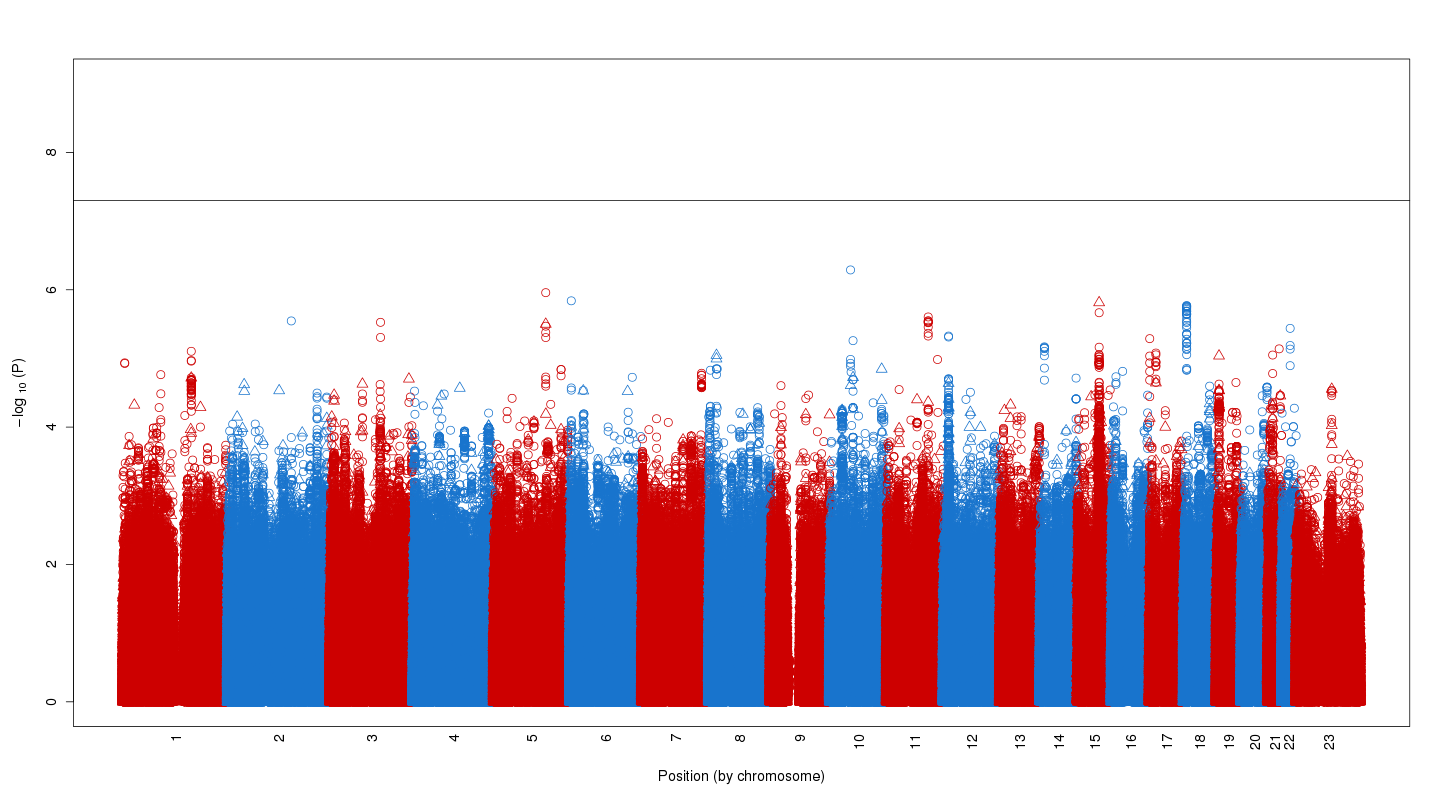

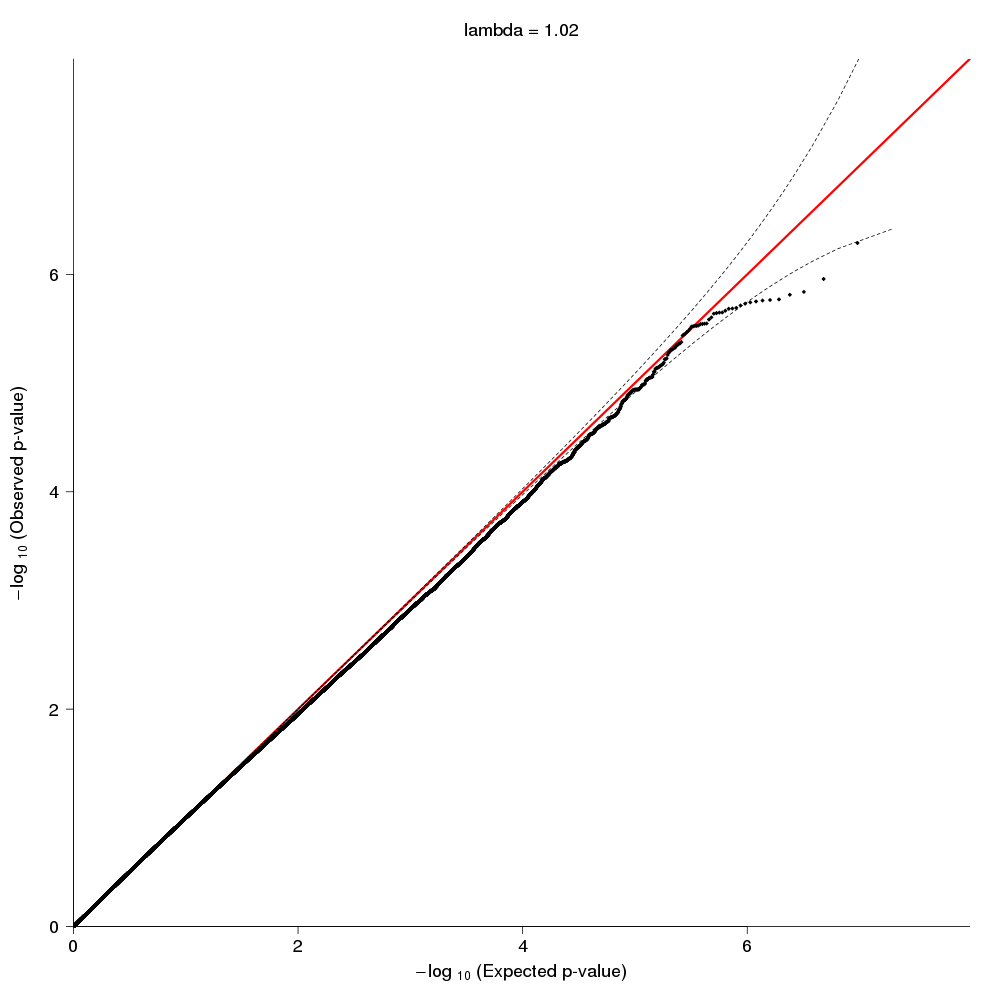

In [10]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/1df/20190225/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/1df/20190225/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  

### P-value Filter

In [ ]:
ancestry=ea
baseDir=/shared/jmarks/hiv/vidus/gwas/ea/1df/001/final

outFile=$baseDir/$study.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001
head -n 1 $baseDir/vidus.ea.1000G_p3.chr6.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats > $outFile
    for (( chr=1; chr<23; chr++ )); do
        echo Processing $baseDir/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
        tail -n +2 $baseDir/vidus.ea.1000G_p3.chr$chr.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats |\
        perl -lane 'if ($F[15] <= 0.001) { print; }' >>  $outFile
done

In [ ]:
## Sort in R ##
finalD <- "/shared/jmarks/hiv/vidus/gwas/ea/1df/001/final/"
pfile <- "vidus.ea.1000G_p3.HIV_ACQ~SNP+AGE+SEX+PC1+PC5+PC9.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    cohort="vidus"
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        dat <- dat[order(dat$p),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

## EA G$\times$Sex GWAS (2df)
**Note1**:  7 individuals removed that had sex discrepancies. See [GitHub issue #42](https://github.com/RTIInternational/bioinformatics/issues/42#issuecomment-465608600).

```
8005964966_NA0054149_93-0143
8005964978_NA0054150_93-0144
8015124413_NA0055272_93-0623
8015124401_NA0055273_93-0624
8015124354_NA0055285_93-0628
8005965380_NA0055556_93-0720
8005964955_NA0056463_93-1068
```

In [ ]:
version="001"
model="2df"
dose_suffix="mach.dose.filtered"
info_suffix="mach.pruned.info"
covars="sex,age,PC1,PC5,PC9"
ancestry="ea"
phenoF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt"
phenoXF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt"
genD=/shared/jmarks/hiv/vidus/genotype/impute/final/$ancestry/mach
phenD=/shared/jmarks/hiv/vidus/phenotype/final
procD=/shared/jmarks/hiv/vidus/gwas/$ancestry/$model/$version

mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}
################################################################################


# autosomes
for chr in {22..1}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}.GxSex.palogist \
        --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palogist \
            --pheno $phenD/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --interaction 2 \
            --out $procD/processing/chr${chr}/chr${chr}.GxSex.palogist.results
done


# chrX
# chrx has a different order phenotype file because the dose file is ordered by sex
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name chr${chr}.GxSex.palogist \
    --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palogist \
        --pheno $phenD/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --interaction 2 \
        --out $procD/processing/chr${chr}/chr${chr}.GxSex.palogist.results

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

### Results Processing
#### Calculate chi, P, and OR

In [ ]:
baseDir=/shared/jmarks/hiv/vidus/gwas/ea/2df/001/processing
study=vidus
ancestry=ea
MODEL=HIV_ACQ~SNP+SNP*SEX+AGE+SEX+PC1+PC5+PC9

for (( chr=1; chr<24; chr++ )); do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ea_$chr \
        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program Rscript ~/bin/calculate_stats_for_probabel_results.R \
            --in_file $baseDir/chr$chr/chr$chr.GxSex.palogist.results_add.out.txt \
            --out_file $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --complete
done

In [ ]:
## check for completion
grep -L "Done" chr*/${study}*log

#### convert name to 1000G_p3

In [ ]:
for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name vidus_1000g_p3_chr${chr}_name \
        --script_prefix chr$chr/name_conversion \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program time perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --file_out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col  0 \
            --file_in_chr_col  1 \
            --file_in_pos_col  2 \
            --file_in_a1_col  3 \
            --file_in_a2_col  4 \
            --chr $chr
done


chr=23
bash /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name vidus_1000g_p3_chr${chr}_name \
    --script_prefix chr$chr/name_conversion \
    --mem 15 \
    --nslots 1 \
    --priority 0 \
    --program time perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --file_out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 1 \
        --file_in_id_col  0 \
        --file_in_chr_col  1 \
        --file_in_pos_col  2 \
        --file_in_a1_col  3 \
        --file_in_a2_col  4 \
        --chr $chr 

In [ ]:
## check for completion
grep -L "Done" ${baseDir}/chr*/name*log

### Filter results
MAF filters in study and 1000G, as well as imputation quality (r^2) filter.

**Note**, according to Fang Fang, when you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.
#### MAF > 0.01 in Study

In [ ]:
## EC2 console ##

# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=ea
    for ((chr=1; chr<24; chr++));do
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted > \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats
    done 
#done

#### MAF > 0.01 in 1000G

In [ ]:
if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
for chr in {1..22};do
    echo "Processing chr$chr"
   awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
done 

# chrX
chr=23
awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}


for chr in {1..23}; do
    idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
    echo "Processing chr${chr}_${ancestry}"      
    /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
        --source ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
        --id_list $idList \
        --out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
        --header 1 \
        --id_column 0 
done 

#### RSQ >= 0.30

In [ ]:
## Filter by R^2
if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi


for chr in {1..23}; do
    echo -e "${ancestry} chr${chr}..."
        awk '{ if ($9 > 0.3){ print $0 } }' \
            $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
             $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
done


## chrX note that imputed data are split up by males & females (229F 709M)
## perform the filtering on both male and female data and then merge results
#chr=23
#echo -e "${ancestry} chr${chr}..."
#zcat $genD/chr$chr/chrX.no.auto_male.info.gz | \
#    tail -n +2 | \
#    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
#    > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp
#
#echo -e "${ancestry} chr${chr}..."
#zcat $genD/chr$chr/chrX.no.auto_female.info | \
#    tail -n +2 | \
#    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
#    >> $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

## keep only SNPs that passed filters for both males and females
#sort $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp |\
#    uniq -d > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep

# Filter results files
cat $procD/processing/chr*/${study}.$ancestry.chr*.tmp | gzip -c > $procD/final/${study}.${ancestry}.hiv_acq.maf_gt_0.01.rsq_gt_0.3.gz


# cleanup
#rm $procD/processing/chr*/*tmp 

### Plot results

In [ ]:
model="2df"
if [ $model == "1df" ]; then
    pcol=10
else
    pcol=13
fi

outfile=$procD/processing/${study}.${ancestry}.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
for (( chr=1; chr<24; chr++ )); do
infile=$procD/final/$study.ea.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
echo Processing $infile
tail -n +2 $infile |
  perl -slne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){13}\s+(\S+)/;
              if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                print join("\t",$1,$2,$3,$6,"snp");
              } else {
                print join("\t",$1,$2,$3,$6,"indel");
              }' -- -pcol >> $outfile
done &

# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 20 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda


In [ ]:
## Get list of variants to filter by imputation quality and MAF
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat $genD/chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# chrX note that imputed data are split up by males & females (229F 709M)
# perform the filtering on both male and female data and then merge results
chr=23
echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_male.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_female.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    >> $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

# keep only SNPs that passed filters for both males and females
sort $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp |\
    uniq -d > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep



# Filter results files
if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi
for chr in {1..23}; do
    if [ $chr == 23 ]; then
        tchr="X"
    else
        tchr=$chr
    fi

    echo "processing $ancestry chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${tchr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
        > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
done &
cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

# cleanup
#rm $procD/processing/chr*/*tmp 


# Make results table
outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile


# convert chrX to chr23 in this table
awk '{if ($2=="X") {$2="23"; gsub("X", "23", $1)}} {print $0}' \
    vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table >\
    tmp && mv tmp vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table


# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 30 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

####   SNP lookup (EA)
Eric O. Johnson requested a lookup of rs4878712—a SNP reported in a prior paper whose G allele reduces the risk of HIV. This SNP's position is 37654257 in the GRCh37 build.

RVTESTS

**CHROM   POS     REF     ALT     N_INFORMATIVE   AF      INFORMATIVE_ALT_AC      CALL_RATE       HWE_PVALUE      N_REF   N_HET   N_ALT   U_STAT  SQRT_V_
STAT    ALT_EFFSIZE     PVALUE**
```
9 37654257   G   A   938     0.442446:0.439749:0.443442      830.028:222.513:607.515 1:1:1   0.321703:0.703252:0.163796      299:78:221     448:128:320     191:47:144   -1.46053  9.38474 -0.0165831 0.876326```

ProbABEL

**name    chrom   position        A1      A2      Freq1   MAF     Quality Rsq     n       Mean_predictor_allele   beta_SNP_addA1 sebeta_SNP_addA1      chi2_SNP_add     chi     p       or_95_percent_ci**
```
rs4878712:37654257:G:A  9       37654257        G       A       0.44264 0.44264 0.99743 0.99155 931     0.443088        -0.0160879      0.107972      0.0222078        0.0222011987186309      0.881553106777208       0.98(0.80-1.22)
```

### View plots
#### EA

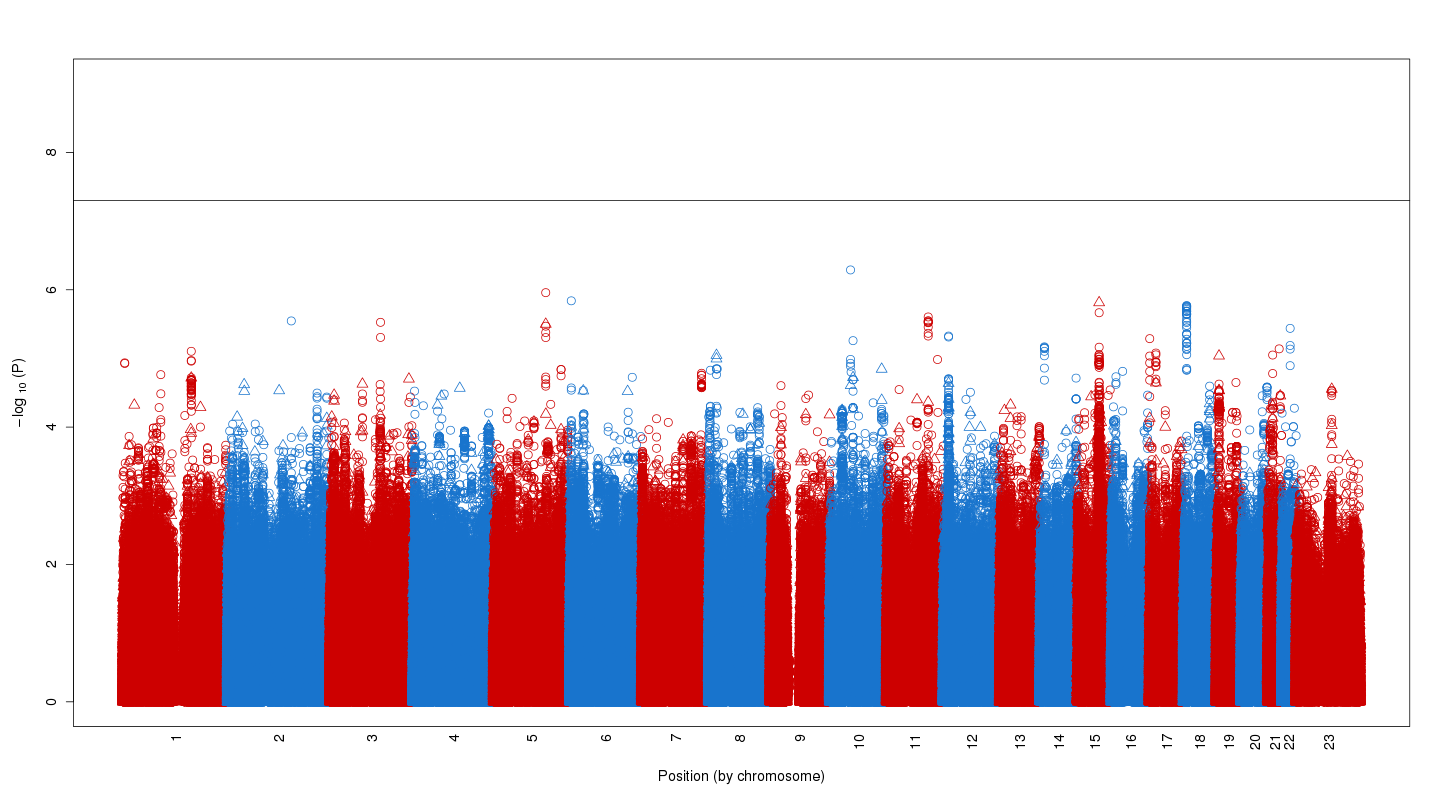

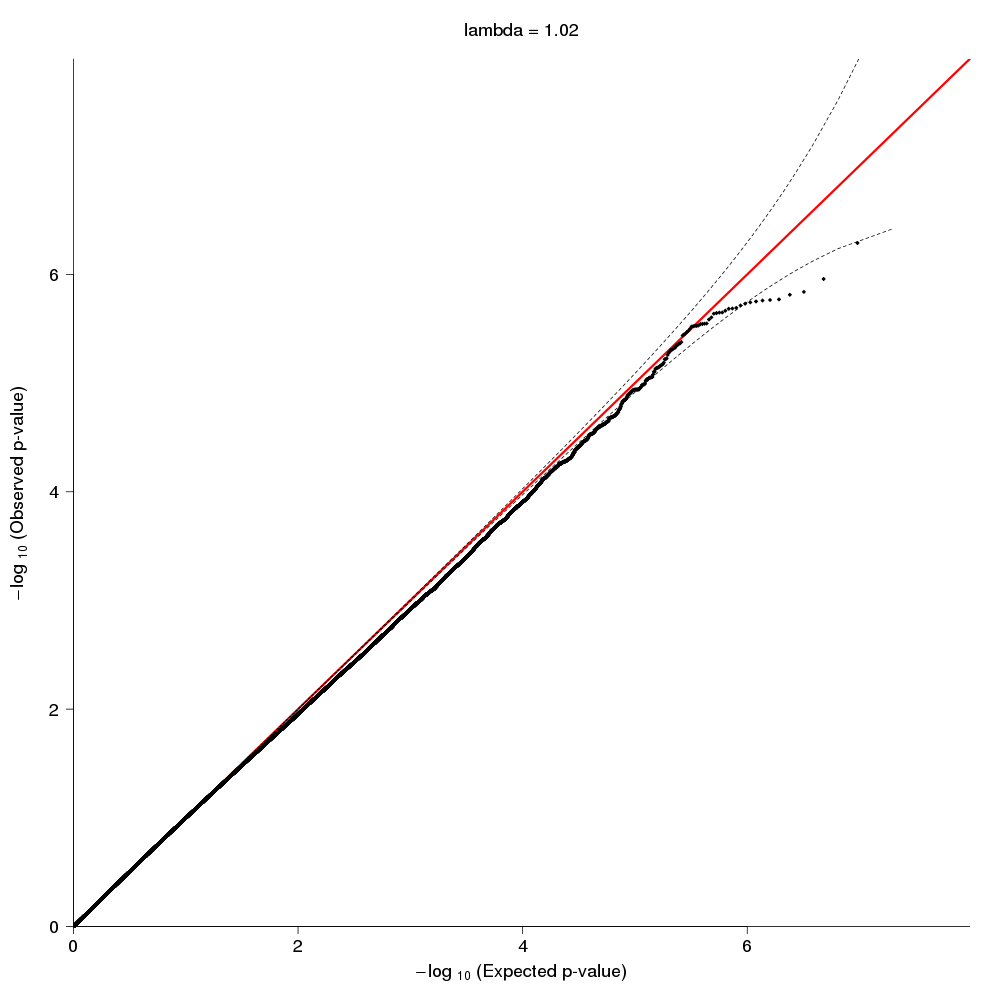

In [9]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/1df/20190225/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/1df/20190225/vidus.ea.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  

# Upload results to S3

In [ ]:
cd 
study="vidus"

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name s3.$study.upload \
    --script_prefix $study.gwas.upload_results \
    --mem 3 \
    --nslots 2 \
    --program aws s3 sync 


study=uhs4
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name s3.$study.upload \
    --script_prefix $study.gwas.upload_results \
    --mem 3 \
    --nslots 1 \
    --program aws s3 sync . s3://rti-heroin/uhs4/data/genotype/observed/20190214/unprocessed

# Sandbox

In [24]:
# compare mine and Fangs Pvalue files
setwd("/Users//jmarks/OneDrive - Research Triangle Institute/Projects/HIV/vidus/gwas/probabel/1df/20190225/compare_pvalues/")

# these two files have been filtered down to the intersection se
jesses <- read.csv("jesses_intersection")
fangs <- read.csv("fangs_intersection")
head(jesses)
head(fangs)

name,chrom,position,A1,A2,Freq1,MAF,Quality,Rsq,n,Mean_predictor_allele,beta_SNP_addA1,sebeta_SNP_addA1,chi2_SNP_add,chi,p,or_95_percent_ci
1:15493822:CAAAAAAAAAAAAAAAAAA:C,1,15493822,CAAAAAAAAAAAAAAAAAA,C,0.55165,0.44835,0.90247,0.72412,931,0.5520920,-0.465469,0.129266,13.1535,12.96621,0.0003171642,0.63(0.49-0.81)***
1:157555142:T:C,1,157555142,T,C,0.04965,0.04965,0.96749,0.44339,931,0.0496633,1.233310,0.347169,12.3180,12.62010,0.0003816219,3.43(1.74-6.78)***
1:3608865:T:G,1,3608865,T,G,0.01282,0.01282,0.99371,0.62490,931,0.0125580,1.974440,0.569719,12.8616,12.01065,0.0005289743,7.20(2.36-22.00)***
1:58839790:G:A,1,58839790,G,A,0.15803,0.15803,0.98677,0.92466,931,0.1575710,-0.602996,0.173502,13.2672,12.07869,0.0005100138,0.55(0.39-0.77)***
1:58839792:G:T,1,58839792,G,T,0.15803,0.15803,0.98675,0.92459,931,0.1575700,-0.603025,0.173510,13.2674,12.07874,0.0005100007,0.55(0.39-0.77)***
1:71063226:C:G,1,71063226,C,G,0.14202,0.14202,0.91340,0.51469,931,0.1413350,0.727882,0.203579,12.5995,12.78368,0.0003496558,2.07(1.39-3.09)***


id,chrom,position,A1,A2,Freq1,MAF,Quality,Rsq,n,Mean_predictor_allele,beta_SNP_addA1,sebeta_SNP_addA1,chi2_SNP_add,chi,p,or_95_percent_ci
1:15493822:CAAAAAAAAAAAAAAAAAA:C,1,15493822,CAAAAAAAAAAAAAAAAAA,C,0.55119,0.44881,0,0.72606,930,0.5507320,-0.442118,0.129733,11.7654,11.61383,0.0006546320,0.64(0.50-0.83)***
1:157555142:T:C,1,157555142,T,C,0.05169,0.05169,0,0.43947,930,0.0516091,1.231850,0.333283,13.5693,13.66122,0.0002189298,3.43(1.78-6.59)***
1:3608865:T:G,1,3608865,T,G,0.01343,0.01343,0,0.62406,930,0.0135091,1.999210,0.560515,13.4907,12.72162,0.0003614529,7.38(2.46-22.15)***
1:58839790:G:A,1,58839790,G,A,0.15652,0.15652,0,0.92634,930,0.1560330,-0.625545,0.174212,14.1660,12.89321,0.0003297767,0.53(0.38-0.75)***
1:58839792:G:T,1,58839792,G,T,0.15651,0.15651,0,0.92628,930,0.1560280,-0.625549,0.174218,14.1653,12.89248,0.0003299042,0.53(0.38-0.75)***
1:71063226:C:G,1,71063226,C,G,0.14452,0.14452,0,0.52921,930,0.1440330,0.712922,0.201746,12.3440,12.48746,0.0004096925,2.04(1.37-3.03)***


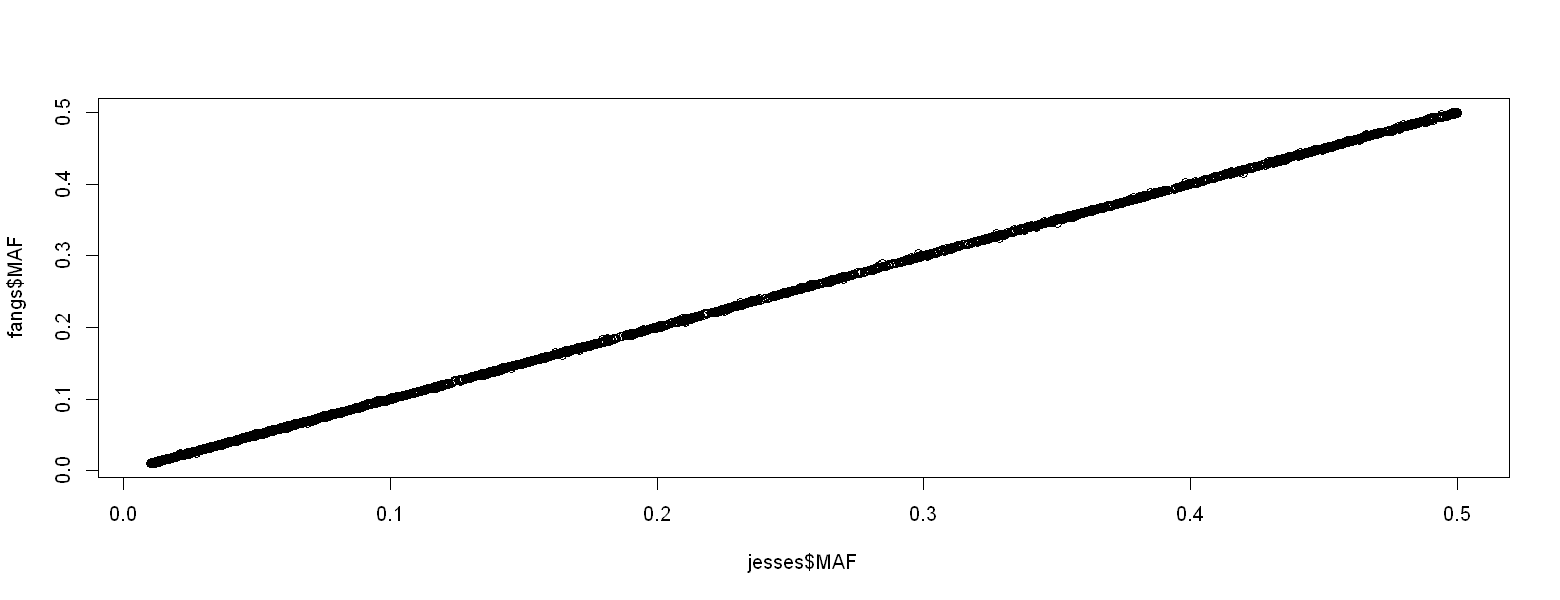

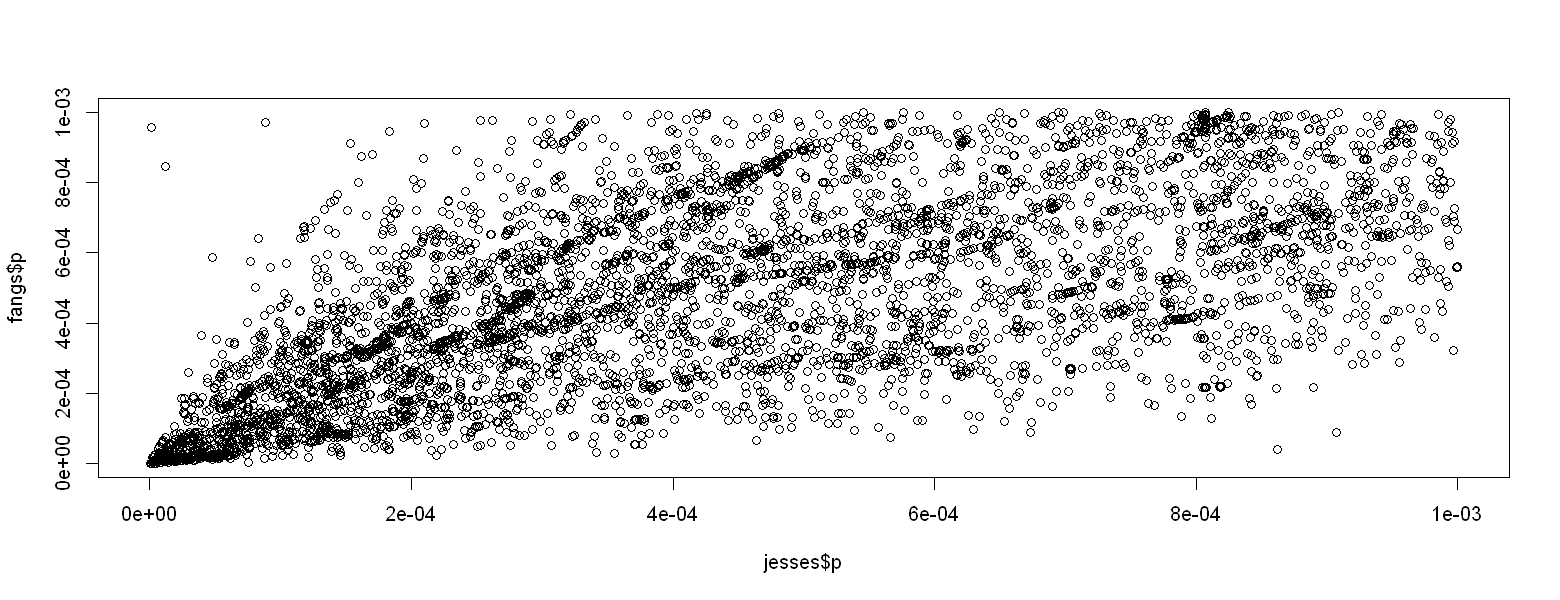

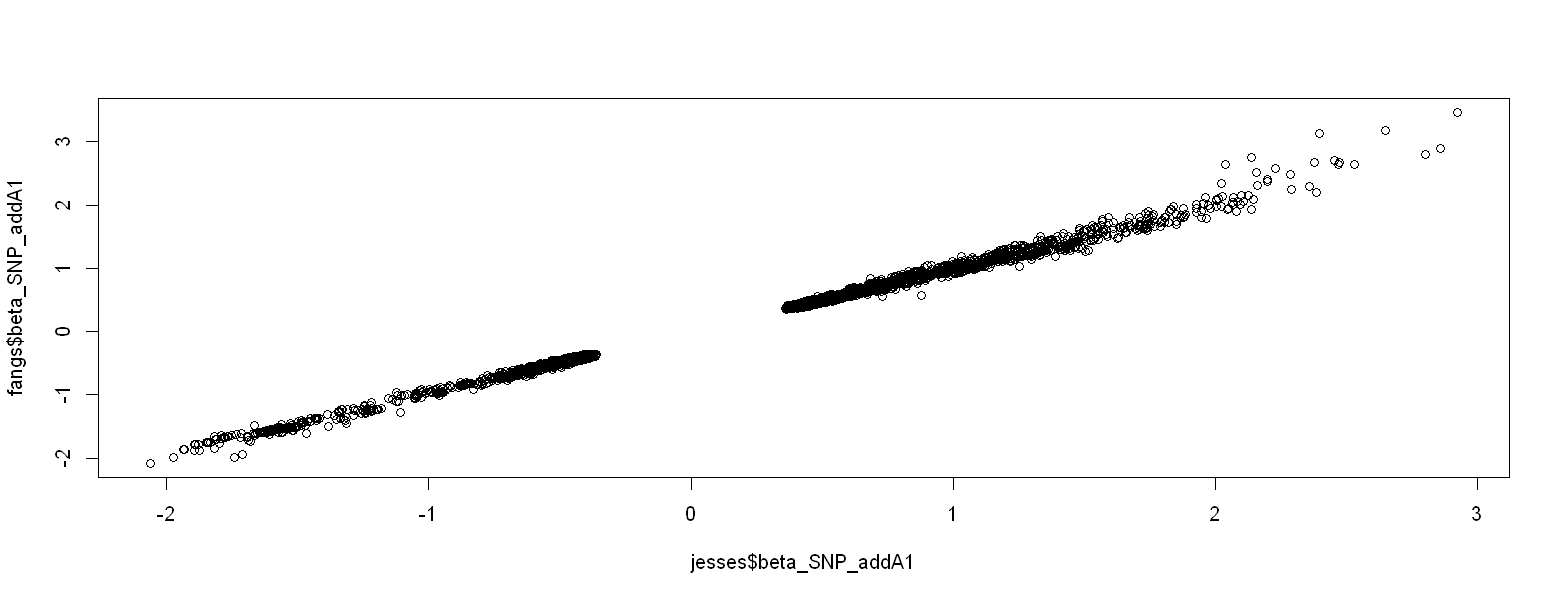

In [46]:
plot(jesses$MAF, fangs$MAF)
plot(jesses$p, fangs$p)
plot(jesses$beta_SNP_addA1, fangs$beta_SNP_addA1)